In [1]:
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option("display.max_columns", 60)
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.5)
import numpy as np
%matplotlib inline


SOURCE_FOLDER = 'Source_data/'

/home/jane/3005/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Выборка 

create table dl_tmp.dt_tins_2020_05_20 as  
select   
ident_source.identnumber  
, a.tcountry as transmitting_country  
, a.reportperiod as reporting_period  
, a.rcountry as rcountry  
, d.docrefid as docrefid  
, d.cordocrefid as cordocrefid   
from dl_tmp.dt_t_identification_registry_viosvo_fs_fl_ident_stg_ident_source ident_source  
join  dl_tmp.il_actual_t_identification_registry_viosvo_fs_accountreport d  
on d.id_fs_fl = ident_source.id_fs_fl  
join dl_tmp.il_actual_t_identification_registry_viosvo_fs_document b  
on b.id = d.id_fs_document  
join dl_tmp.il_actual_t_identification_registry_viosvo_fs_journalin a  
on a.id = b.id_fs_journalin  
where  
a.typeinfid is not null  
and d.doctypeind in ('OECD1','OECD2','OECD3') 
and a.id in (select f.id_fs_journalin  
  	from dl_raw.viosvo_fs_status f  
  	where f.probr = '01');  

  
select * from dl_tmp.dt_tins_2020_05_20;    

In [2]:
%%time
data_raw = pd.read_csv(SOURCE_FOLDER + 'identnumber_simplified.csv', delimiter = ';', encoding="ISO-8859-1")
# Save data to .feather format for fast loading
# data_raw.to_feather(SOURCE_FOLDER + 'identnumber.feather')

CPU times: user 3.26 s, sys: 277 ms, total: 3.54 s
Wall time: 3.54 s


In [3]:
# %%time
# data_raw = pd.read_feather(SOURCE_FOLDER + 'identnumber.feather')

In [4]:
data_raw.shape

(3303336, 6)

Всего в выборке 3 303 336 строк

In [5]:
data_raw.columns

Index(['identnumber', 'transmitting_country', 'reporting_period', 'rcountry',
       'docrefid', 'cordocrefid'],
      dtype='object')

In [6]:
data_raw.head()

,identnumber,transmitting_country,reporting_period,rcountry,docrefid,cordocrefid
0,700646031,RU,2017-12-31,RU,RU2017-7704113772-BB86A4F7-9C9D-E641-9201-B0FF...,NaN
1,57310864903,RU,2017-12-31,RU,RU2017-7414006722-BBA8F581-0FBC-694F-BA94-1384...,NaN
2,784-1950-6908293-1,RU,2017-12-31,RU,RU2017-7744000912-9795EFEF-453C-E148-B168-6CF3...,NaN
3,784-1950-6908293-1,RU,2017-12-31,RU,RU2017-7744000912-B6D0378E-B1BA-7349-A3CA-5D9C...,NaN
4,784-1950-6908293-1,RU,2017-12-31,RU,RU2017-7744000912-06CB3AA4-2A34-994B-B716-9094...,NaN


In [7]:
data_raw.identnumber.value_counts().head(10)

XX                 2332050
0                    87556
AAAAAAAAA            51789
000000000            41865
noTINavailable       27594
0000                 21264
999999999             9659
999999999999999       8110
NOTIN                 2981
1                     2969
Name: identnumber, dtype: int64

In [8]:
# rcountry - Страна получатель 
data_raw.rcountry.value_counts()

RU    3303236
Name: rcountry, dtype: int64

100 строк пусто

In [9]:
# fin_country - Наименование страны финансовой организации
# transmitting_country - Код государства, отправившего сведения об идентифицируемом лице
data_raw.transmitting_country.value_counts().head()

RU    2570738
CY     193517
FI      70539
BG      66837
CZ      51474
Name: transmitting_country, dtype: int64

In [10]:
data_tin_rus = data_raw[(data_raw['transmitting_country'] != 'RU')] 
data_tin_rus.shape

(732598, 6)

In [11]:
data_tin_rus.reset_index(drop = True, inplace = True)

In [12]:
cordocrefid = data_tin_rus.cordocrefid[data_tin_rus['cordocrefid'].str.contains('.', case = False, 
                                                                                    regex=True, na=False)]
print('Number of cordocrefid: ', cordocrefid.shape[0])

def filter_actual_docrefid(docref):

    if docref in cordocrefid.values:
        return False
    else:
        return True

Number of cordocrefid:  13079


In [13]:
%%time
mask_docrefid = data_tin_rus['docrefid'].map(filter_actual_docrefid)
mask_docrefid.value_counts()

CPU times: user 2min 22s, sys: 679 ms, total: 2min 22s
Wall time: 2min 21s


True     719524
False     13074
Name: docrefid, dtype: int64

In [14]:
data_actual = data_tin_rus[mask_docrefid]
data_actual.shape

(719524, 6)

In [15]:
data_actual['reporting_period'] = data_actual['reporting_period'].astype('str')
data_actual['reporting_year'] = data_actual.reporting_period.apply(lambda x: x[:4])

/home/jane/3005/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jane/3005/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
data_actual['reporting_year'].value_counts()

2018    362313
2017    341603
2019      8798
2016      6710
nan        100
Name: reporting_year, dtype: int64

In [17]:
data = data_actual[data_actual['reporting_year'] == '2018']
data.reset_index(drop = True, inplace = True)
data.shape

(362313, 7)

In [18]:
data.identnumber.value_counts().head(25)

AAAAAAAAA        37493
000000000        27599
0000              7152
0                 4163
1                 2687
NOTIN             2531
X                 1650
-1                1405
00000             1181
000000             826
770472522269       504
AAAAA              477
UNKNOWN            453
XX                 417
XXXXXXXXX          401
0000000000         323
AAAAAAAAAA         312
999                254
na                 248
.                  230
TINNOTAVBL         184
NOT AVAILABLE      173
xxxxxxxx           139
000-00-0000        130
XXXXXX             126
Name: identnumber, dtype: int64

In [19]:
data.identnumber.value_counts().head(23).sum()*100/data.identnumber.shape[0]

25.061755995506648

Как минимум около 45 % всей выборки представляют собой не идентификационные номера

## Критерии качества

**TIN**  
1. **пропущенные значения** - те строки, в которых тин вообще ни в каком виде не указан
2. **нерелевантные данные** - тины, не содержащие цифры либо не похожие на номер (н-р, AAAAAAAAA, noTINavailable, 99999999999, 1, -1)
3. **неполные данные** - тины, содержащие мало цифр для идентификации (надо решить, например, 4 цифры мы можем использовать для идентификации как серию? или начать с 6 - номер паспорта либо 7 - номер заграна)
4. **данные с дополнительными цифрами** - лишние цифры в номере документа, представляющие собой шум (00 в начале) либо склееные 2 типа документа
5. **зашумленные данные** - вперемежку с буквами, словами, знаками и т.д
6. **скрываемые данные** - 1 в верхнем регистре вместо обычной единицы, D вместо 0, B вместо 8




## Вероятность идентификации:
min - % тинов, которые указаны в правильном цифровом формате, количество символов соответствует количеству символов в российских документах

max - % тинов, которые можно привести к правильному формату путем многочисленных преобразований  

In [20]:
mask_digit = data.identnumber.str.contains('\d', regex=True, na=False)
mask_digit.value_counts()

True     313037
False     49276
Name: identnumber, dtype: int64

In [21]:
tins_only_with_digits = data.identnumber.loc[mask_digit]
tins_only_with_digits

0         540542373805
1         540608438220
2         772810417128
3         301511947592
4         590416261878
              ...     
362308        19850421
362309        19870706
362310    250306262459
362311        5,03E+11
362312    501105888334
Name: identnumber, Length: 313037, dtype: object

In [22]:
twd = tins_only_with_digits.shape[0]/data.shape[0]
print('Содержат цифры: {} %'.format(round(twd*100)))

Содержат цифры: 86 %


In [23]:
# data.tin = data.tin.fillna('')

In [24]:
mask_only_digits=tins_only_with_digits.apply(lambda x: bool(re.match('^[0-9]+$', x)))
tins_only_digits = tins_only_with_digits[mask_only_digits]

In [25]:
tins_only_digits

0         540542373805
1         540608438220
2         772810417128
3         301511947592
4         590416261878
              ...     
362307        19880813
362308        19850421
362309        19870706
362310    250306262459
362312    501105888334
Name: identnumber, Length: 253675, dtype: object

In [26]:
mask_with_letters = np.invert(tins_only_with_digits.index.isin(tins_only_digits.index))
tins_letter_digit = tins_only_with_digits.loc[mask_with_letters]
tins_letter_digit

15         ITN7704746951
31            INN 504500
176           10.07.1972
177           19.02.1960
178           23.09.1983
               ...      
362173        75339*2624
362302     RIIG590329U76
362303    1234 100001 02
362305        KOAN910612
362311          5,03E+11
Name: identnumber, Length: 59362, dtype: object

In [27]:
tod = tins_only_digits.shape[0]/data.shape[0]
tld = tins_letter_digit.shape[0]/data.shape[0]
print('Содержат только цифры: {} %'.format(round(tod*100)))
print('Содержат цифры/буквы/символы: {} %'.format(round(tld*100)))

Содержат только цифры: 70 %
Содержат цифры/буквы/символы: 16 %


Из тех, что содержат буквы и цифры 258 741 (86%) содержат только цифры и 41 683 (14%) цифры и буквы,а от общей выборки 76 и 12 % соответственно

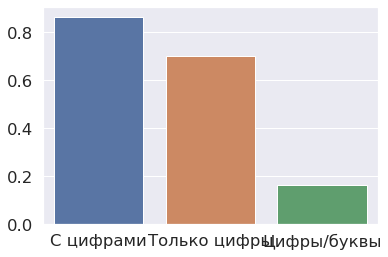

In [28]:
sns.barplot(['C цифрами', 'Только цифры', 'Цифры/буквы'],[twd, tod, tld]);

## Анализ TIN, состоящих только из цифр

In [29]:
tins_only_digits.value_counts().head(20)

000000000          27599
0000                7152
0                   4163
1                   2687
00000               1181
000000               826
770472522269         504
0000000000           323
999                  254
7707083893           120
773310743213         118
000000000000000      101
773398108093          97
781411168717          91
771511932496          84
199408040393          80
770975045679          71
99                    70
771200536436          70
781100278080          65
Name: identnumber, dtype: int64

In [30]:
tins_only_digits.map(len).value_counts()

12    167911
9      37333
10     13736
11     10349
4       7249
1       6861
8       3891
5       1654
13      1349
6       1274
7        879
3        390
15       303
2        135
16       120
14       112
18        44
23        26
20        19
19        16
17        12
32        10
24         1
21         1
Name: identnumber, dtype: int64

Слева количество цифр в TIN, справа частота TIN с таким количеством цифр. 

In [31]:
# tins_only_digits.map(len).value_counts().head(4).sum()*100/tins_only_digits.shape[0]

In [32]:
x_9_10_12_15 = (tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 9)].shape[0]+
tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 10)].shape[0]+
tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 12)].shape[0]+
tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 15)].shape[0])/data.shape[0]

x_9 = (tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 9)]
       .shape[0])/data.shape[0]

x_10 = (tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 10)]
       .shape[0])/data.shape[0]

x_12 = (tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 12)]
       .shape[0])/data.shape[0]

x_15 = (tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 15)]
       .shape[0])/data.shape[0]

print('9,10,12,15 цифр: {} %'.format(round(x_9_10_12_15*100)))
print('9 цифр: {} %'.format(round(x_9*100)))
print('10 цифр: {} %'.format(round(x_10*100)))
print('12 цифр: {} %'.format(round(x_12*100)))
print('15 цифр: {} %'.format(round(x_15*100,2)))

9,10,12,15 цифр: 61 %
9 цифр: 10 %
10 цифр: 4 %
12 цифр: 46 %
15 цифр: 0.08 %


Итого подходящих под искомые документы (ИНН, Паспорт росс., паспорт загран, ЕГРНИП) около 47 % 

In [33]:
num_digits = ['<9', '9', '10', '12', '15', '11, 13, 14 & > 15']
counts = [tins_only_digits[tins_only_digits.apply(lambda x: len(x) <= 8)].shape[0],
         tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 9)].shape[0],
         tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 10)].shape[0],
         tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 12)].shape[0],
         tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 15)].shape[0],
         tins_only_digits[tins_only_digits.apply(lambda x: len(x) > 10 and len(x) != 12 and 
                                                           len(x) != 15)].shape[0]]

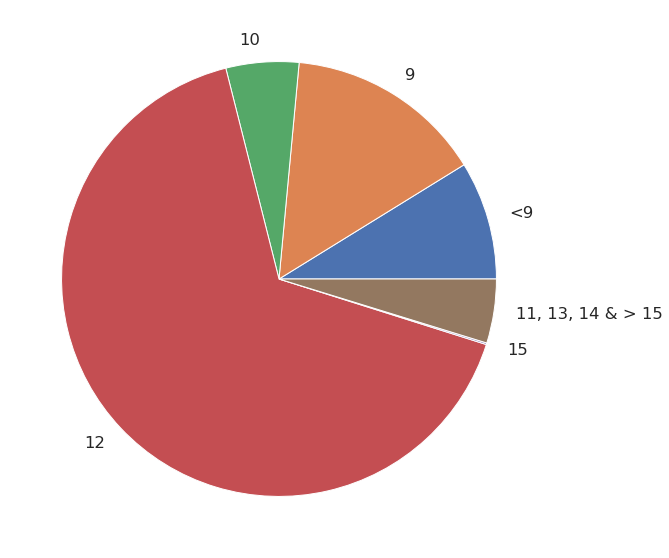

In [34]:
fig1, ax1 = plt.subplots(figsize = [10,10])
ax1.pie(counts, labels=num_digits)
plt.show()

In [35]:
t_less9 = tins_only_digits[tins_only_digits.apply(lambda x: len(x) < 9)].shape[0]/data.shape[0]
print('Менее 9 цифр: {} %'.format(round(t_less9*100)))

Менее 9 цифр: 6 %


In [36]:
tins_only_digits.map(len).value_counts().sort_index().head(8)

1    6861
2     135
3     390
4    7249
5    1654
6    1274
7     879
8    3891
Name: identnumber, dtype: int64

Частота TIN до 9 цифр для наглядности по порядку

In [37]:
tins_only_digits[tins_only_digits.apply(lambda x: len(x) > 10 and len(x) != 12 and len(x) != 15)].map(len).value_counts().sort_index()

11    10349
13     1349
14      112
16      120
17       12
18       44
19       16
20       19
21        1
23       26
24        1
32       10
Name: identnumber, dtype: int64

In [38]:
tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 7)].value_counts()

5555555    15
0029160    14
0946444    13
1382844    11
2632363    11
           ..
6455210     1
1002199     1
0598034     1
2041997     1
1222497     1
Name: identnumber, Length: 481, dtype: int64

1107 шт по 7 символов, возможно только номер документа загран паспорта

In [39]:
tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 8)].value_counts()

14001105    61
99999999    33
00000000    33
61544057    25
29871961    17
            ..
19680115     1
08240387     1
19370926     1
46601171     1
75669789     1
Name: identnumber, Length: 2251, dtype: int64

Возможно просто пропущена цифра. Можно использовать TIN по 8 цифр, например, так. Идет проверка по TIN + 1 цифра (0-9) в конце либо в начале, дополнительно проверяя по другим полям. А можно и в середине, но это, конечно, долгий цикл получится. 

Частота TIN более 10 цифр 

In [40]:
t_9_0 = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 9)].value_counts()[0]/data.shape[0]
print('TIN 9 нулей: {} %'.format(round(t_9_0*100)))

TIN 9 нулей: 8.0 %


In [41]:
tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 11)].value_counts()

77050819568    63
12814762157    32
78390226734    21
51152709141    18
97319239670    18
               ..
15876912220     1
16106803839     1
24059522619     1
92762351800     1
00121618875     1
Name: identnumber, Length: 4940, dtype: int64

In [42]:
tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 13)].value_counts()

8830724030018    34
7801051702200    16
5008077072102    15
9000000487081    15
8109218456222    12
                 ..
2631115400076     1
7565615455698     1
8707206340016     1
7801717610269     1
2537146005315     1
Name: identnumber, Length: 674, dtype: int64

In [43]:
tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 15)].value_counts().head()

000000000000000    101
304312322600100     14
177431825031478      5
111111111111111      4
790812772207111      4
Name: identnumber, dtype: int64

In [44]:
x_15_9_0 = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 15)].value_counts().head(2).sum()/tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 15)].shape[0]
print('15 девяток или нулей: {} %'.format(round(x_15_9_0*100)))

15 девяток или нулей: 38.0 %


## Анализ TIN, содержащих буквы/цифры

In [45]:
tins_letter_digit.shape

(59362,)

59 362 или 16% всех записей представляют собой смесь букв и цифр

In [46]:
tins_letter_digit.value_counts().head(20)

-1                         1405
000-00-0000                 130
7727DD748430                 89
RU552800544947               73
NRDFNC54S18G224M             67
772833326648RESIDENT ID      65
INN773624467928              58
521-79-4401                  49
RCCRRT70R14F205N             48
7728168971IDDENTY CARD       42
FDRVDM58R11Z154D             40
344 544 107342               39
GBRGRO66P49Z135M             37
15033225RUSSIAN ID           35
INN784806748568              32
070379-220D                  32
INN773624471089              31
Z2018834                     30
RGGDVD49T22E329O             30
580969-19148                 29
Name: identnumber, dtype: int64

Наиболее распространенные TIN, в которых присутствуют не только цифры

In [47]:
tins_letter_digit.map(len).value_counts()

10    23919
16    13260
11    10556
14     4534
2      1407
15     1269
9       931
12      720
8       650
13      560
7       492
18      265
17      185
6       139
20       89
23       70
22       54
19       50
32       45
21       44
31       28
4        17
28       16
24       15
26       15
5         9
27        8
25        4
44        3
30        3
36        3
45        1
42        1
Name: identnumber, dtype: int64

In [48]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 10)].value_counts()

10.02.1994    29
17.10.1948    25
24.03.1975    22
30.07.1974    20
09.12.1967    20
              ..
84761870HD     1
400139560R     1
60N3956752     1
400136882B     1
400108374R     1
Name: identnumber, Length: 11434, dtype: int64

In [49]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 16)].value_counts()

NRDFNC54S18G224M    67
RCCRRT70R14F205N    48
FDRVDM58R11Z154D    40
GBRGRO66P49Z135M    37
RGGDVD49T22E329O    30
                    ..
PRSLNE59R50Z254R     1
SPLLLA77L54Z135Z     1
PLSGPP81A16F839F     1
PDDPLA81M12A192M     1
NZRVRY60S29Z154N     1
Name: identnumber, Length: 8639, dtype: int64

In [50]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 11)].value_counts()

000-00-0000    130
521-79-4401     49
070379-220D     32
070208A593A     26
250306A547R     26
              ... 
281088-278T      1
300760-232Y      1
160492-311A      1
1.48112E+12      1
220199-6993      1
Name: identnumber, Length: 6497, dtype: int64

In [51]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 9)].value_counts()

M1M514693    23
08026624Q    12
6726496RP    10
SC935093B    10
08057253Y     8
             ..
01327037Q     1
335502-06     1
RH0533256     1
7.738E+11     1
05708031Y     1
Name: identnumber, Length: 511, dtype: int64

In [52]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 19)].value_counts().head(10)

1700008857PERMIT NO    14
R2290274PASSPORT NO     5
W201666432330113932     3
INN 665 901 499 163     3
BYDVTR68R16Z16Z154N     2
04 21 456 563 115 C     2
RUSSIA-773177467721     2
29636135 CZ29036135     1
SINO 6576656PASPORT     1
TINO NO540531446089     1
Name: identnumber, dtype: int64

In [53]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 8)].value_counts().head(10)

Z2018834    30
Z3218199    18
Z3558542    12
7,73E+11    11
7.73E+11    10
Z2072858     9
OMC78039     8
M1M87181     8
7,70E+11     8
MAA30442     8
Name: identnumber, dtype: int64

In [54]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 14)].value_counts()

RU552800544947    73
344 544 107342    39
M1N450838ID NO    27
RU860405931583    17
RU772823319431    17
                  ..
7705 0259 4619     1
RU782590059689     1
RU772008928133     1
77180 334 1275     1
165-063-281-56     1
Name: identnumber, Length: 1916, dtype: int64

In [55]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 24)].value_counts().head(10)

7715040601TINWORK PERMIT    8
BIC 0445257000TIN NO BIN    2
41065507418,773302356644    1
28585054820,504401652773    1
31272972977,540808447293    1
57832973097,500805485390    1
72262061129,771543788196    1
Name: identnumber, dtype: int64

In [56]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 15)].value_counts().head(10)

INN773624467928    58
INN784806748568    32
INN773624471089    31
770 507 456 940    25
773168837207INN    19
890106953411TIN    16
INN443100613027    15
770508459704INN    14
INN773015431425    13
632.302.378.408    11
Name: identnumber, dtype: int64

In [57]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 20)].value_counts().head(10)

7709009454/771501001    5
7710532690/503601001    5
RUNHH.771003-7111-99    4
7805018099/997250001    3
82N0592597GREEN CARD    3
7722005113 771801001    3
5011021227/501101001    3
JK12 RCF RUS 38 2015    2
7719793009/771901001    2
7706097558/770601001    2
Name: identnumber, dtype: int64

In [58]:
tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 18)].value_counts().head(10)

15033225RUSSIAN ID    35
W20176432950856656     9
W20186431315035065     6
W20185432113177367     6
RUS000000721061691     5
INN 7725 8014 3656     4
W20162501313516428     4
RUS6810203M2306119     4
567-413.60.409.153     4
RUS5803033M2310303     4
Name: identnumber, dtype: int64

In [59]:
mask_ru = data.identnumber.str.contains('ru', case = False, regex=False, na=False)
tins_ru = tins_letter_digit[mask_ru]
tins_ru

1024      P RUS 53 1055558
1239                 RU207
1743            RU25101990
1894          RU9857229999
1956           RUS20000218
                ...       
360516      RU301512347220
360517      RU645320056476
360518      RU770702876434
360519      RU550700018591
360520        RU3324808501
Name: identnumber, Length: 2881, dtype: object

1767 записей в которых присутствуют буквы RU

In [60]:
tins_erase_char = tins_ru.apply(lambda x: re.sub('[A-Z,a-z,/!@#$,.();:\-%? ]', '', x))
# tins_erase_char[tins_erase_char.map(len)>6]
tins_erase_char

1024         531055558
1239               207
1743          25101990
1894        9857229999
1956          20000218
              ...     
360516    301512347220
360517    645320056476
360518    770702876434
360519    550700018591
360520      3324808501
Name: identnumber, Length: 2881, dtype: object

In [61]:
#проверка
mask_ru_only_digits = tins_erase_char.apply(lambda x: bool(re.match('^[0-9]+$', x)))
tins_ru_only_digits = tins_erase_char[mask_ru_only_digits]
tins_ru_only_digits.shape

(2881,)

In [62]:
tins_ru_only_digits.map(len).value_counts()

12    2403
11      97
8       97
9       83
10      64
7       35
14      34
13      23
15      12
24      11
6        9
5        8
3        2
23       1
17       1
16       1
Name: identnumber, dtype: int64

Частота TIN с RU, RUS c различной длинной символов

In [63]:
# mask_without_ru = tins_letter_digit.index.isin(tins_ru.index)
# tins_letter_digit = tins_letter_digit[np.invert(mask_without_ru)]

Далее рассматриваются буквенные коды других стран СНГ, что не выглядит полезным  
Кроме того выделены тины с определенными словами 

In [64]:
mask = data.identnumber.str.contains('kz', case = False, regex=False, na=False)
tins_letter_digit[mask].head()

10115    KZNGRI86A13Z135O
10213    PKZLNE69T70Z135C
10248    KZDSKR94T21Z154V
10347    KZHLNO80R45Z138Y
10365    KZMRNI77P53Z135O
Name: identnumber, dtype: object

In [65]:
mask = data.identnumber.str.contains('by', case = False, regex=False, na=False)
tins_letter_digit[mask].head()

10194    BYKNTL65B53Z154F
10283    BYKVNY52A19Z154M
10606    BYCVLR83A55Z135X
10853    BYSVNY65S22Z135Z
11158    BYDVTR71H65Z154U
Name: identnumber, dtype: object

In [66]:
mask = data.identnumber.str.contains('ua', case = False, regex=False, na=False)
tins_letter_digit[mask].head()

29808                         QUAFNC42B10E833W
67845                         QUAFNC42B10E833W
67861                         QUAFNC42B10E833W
68895                     FR19780309RomuaIntar
103650    9909391238INDIVIDUAL TAXPAYER NUMBER
Name: identnumber, dtype: object

In [67]:
mask = data.identnumber.str.contains('lv', case = False, regex=False, na=False)
tins_letter_digit[mask].head()

4215     BGNLVR39E02E229W
10156    LVCNTS91L52Z135W
10311    RLVMRN61B62Z154Y
10401    RLVNLK69P50Z154Y
10413    FRLVNY89M31Z154F
Name: identnumber, dtype: object

In [68]:
mask = data.identnumber.str.contains('lt', case = False, regex=False, na=False)
tins_letter_digit[mask].head()

10100    KLTSTL81B50Z154F
10457    DLTNTN70R19Z135E
10481    LTVVNY86D56Z154H
10552    BLTNIA91D63Z154I
10628    NLTRNI80C48Z135W
Name: identnumber, dtype: object

Заменяю скрытые символы:'¹' -> '1', 'D', 'O' -> '0', 'B' -> '8'

In [69]:
mask = tins_letter_digit.str.contains('¹', case = False, regex=False, na=False)
print(mask.value_counts())
tins_letter_digit = tins_letter_digit.str.replace('¹','1')

False    59362
Name: identnumber, dtype: int64


In [70]:
mask = tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 12)].str.contains('D', case = False, regex=False, na=False)
print(mask.value_counts())
tins_letter_digit = tins_letter_digit.str.replace('D','0')

False    619
True     101
Name: identnumber, dtype: int64


In [71]:
mask = tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 12)].str.contains('D', case = False, regex=False, na=False)
print(mask.value_counts())
tins_letter_digit = tins_letter_digit.str.replace('B','8')

False    720
Name: identnumber, dtype: int64


In [72]:
mask = tins_letter_digit[tins_letter_digit.apply(lambda x: len(x) == 12)].str.contains('D', case = False, regex=False, na=False)
print(mask.value_counts())
tins_letter_digit = tins_letter_digit.str.replace('O','0')

False    720
Name: identnumber, dtype: int64


In [73]:
101/data.shape[0]

0.00027876449368363816

Разделяю, очищаю тины из выборки буквы/цифры (там еще и символы)

In [74]:
# inns = ['INN 665 901 499 163', '3608136691RU1308193601', '7194180974RUS5308011M2205', '4016728114RUS7111114' ,
#         '51 3346352 21/03/1957','7718232025','58317290948 INN:772811309943','7718232025 771801001',
#         '7716615897/771601001','7720657593   772001001', '317 103 100987 0006', '04 21 456 563 115 C',
#         'Passport No: 71 6289698', 'PASSPORT No: 71 6289698', 'P RUS 53 1055558']

# inns = pd.Series(inns)

def split_clean_id(docs):
    
    docs = docs.apply(lambda x: re.sub(r'\bPASSPORT\b|\bPassport\b|\bpassport\b', '', x))
    
    docs = docs.values
    
    split_docs = []
    
    for d in docs:
        
        # Если пробел присутствует в первых 8 символах, то убираем его, т.к. документа < 9 символов у нас нет, 
        # делить по этому пробелу нет смысла
        if ' ' in d[:8]:
            d = "".join(d.split(" ", 1))
        
        # Разделяем каждый номер по пробелам, /,  RUS, RU 
        l = re.split('/|\s\s|\s|RUS|RU', d)
        
        # Оставляем только те, что длиннее 7 символов
        li = [n for n in l if len(n) > 7]
        
        # Если все компоненты короче 7 символов, считаем, что разделение ошибочно, и возвращаем как было
        if li == []:
            li = [d]
        
        # Формируем итоговый список, удаляя буквы/символы 
        for i in li:
            
            i = re.sub('\D', '', i)
            split_docs.append(i)
            
        split_docs = [s for s in split_docs if s != '']
    
    return(split_docs)

#[A-Z,a-z,/!@#$,.();:~\-%?&°\\+*\n|"\'`_\[\] ]

In [75]:
clean_tins = split_clean_id(tins_letter_digit)
len(clean_tins)

59431

In [76]:
len(clean_tins) - tins_letter_digit.shape[0]

69

После обработки количество тинов увеличилось с 59362 до 59431 (69 за счет разделения)

In [77]:
#Проверка
tins_ld_only_digits = [x for x in clean_tins if bool(re.match('^[0-9]+$', x))]
len(tins_ld_only_digits)

59431

Частота тинов с различной длиной символов

In [78]:
clean_tins = pd.Series(clean_tins)
clean_tins.map(len).value_counts()

8     23584
9     14258
7      6539
10     4806
12     4044
11     2371
1      1421
6       698
5       688
14      319
13      221
4       207
17      139
15       59
2        29
16       17
3        16
23        6
18        6
19        1
22        1
29        1
dtype: int64

In [79]:
t_less9_l = clean_tins[clean_tins.apply(lambda x: len(x) < 9)].shape[0]/data.shape[0]
print('Менее 9 цифр: {} %'.format(round(t_less9_l*100)))

Менее 9 цифр: 9 %


In [80]:
clean_tins[clean_tins.apply(lambda x: len(x) == 8)].shape[0]/data.shape[0]

0.06509288929737547

In [81]:
x_9_10_12_15_l = (clean_tins[clean_tins.apply(lambda x: len(x) == 9)].shape[0]+
clean_tins[clean_tins.apply(lambda x: len(x) == 10)].shape[0]+
clean_tins[clean_tins.apply(lambda x: len(x) == 12)].shape[0]+
clean_tins[clean_tins.apply(lambda x: len(x) == 15)].shape[0])/data.shape[0]

x_9_l = (clean_tins[clean_tins.apply(lambda x: len(x) == 9)]
       .shape[0])/data.shape[0]

x_10_l = (clean_tins[clean_tins.apply(lambda x: len(x) == 10)]
       .shape[0])/data.shape[0]

x_12_l = (clean_tins[clean_tins.apply(lambda x: len(x) == 12)]
       .shape[0])/data.shape[0]

x_15_l = (clean_tins[clean_tins.apply(lambda x: len(x) == 15)]
       .shape[0])/data.shape[0]

print('9,10,12,15 цифр: {} %'.format(round(x_9_10_12_15_l*100,2)))
print('9 цифр: {} %'.format(round(x_9_l*100,2)))
print('10 цифр: {} %'.format(round(x_10_l*100,2)))
print('12 цифр: {} %'.format(round(x_12_l*100,2)))
print('15 цифр: {} %'.format(round(x_15_l*100, 2)))

9,10,12,15 цифр: 6.39 %
9 цифр: 3.94 %
10 цифр: 1.33 %
12 цифр: 1.12 %
15 цифр: 0.02 %


## Проверка ИНН

In [82]:
def validate_inn(inn):
    
    weights1 = [7,2,4,10,3,5,9,4,6,8,0]
    weights2 = [3,7,2,4,10,3,5,9,4,6,8,0]
    
    control_sum1 = 0
    for i,j in zip(weights1, inn[:-1]):
        control_sum1 += i*int(j)
    
    residuals1 = control_sum1 % 11
    if residuals1 > 9:
        residuals1 = residuals1 % 10
    
    control_sum2 = 0
    for i,j in zip(weights2, inn):
        control_sum2 += i*int(j)
    residuals2 = control_sum2 % 11
    if residuals2 > 9:
        residuals2 = residuals2 % 10
    
    if (residuals1 == int(inn[-2])) & (residuals2 == int(inn[-1])):
        return True
    else:
        return False

In [83]:
inn = '773581571984'
validate_inn(inn)

True

Проверка ИНН на валидность для 12-ти символьных тинов (только цифры)

In [84]:
mask_true_inn = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 12)].map(validate_inn)
mask_true_inn.value_counts()

True     160826
False      7085
Name: identnumber, dtype: int64

In [85]:
ti = len(mask_true_inn[mask_true_inn==True])/data.shape[0]
print('Валидные ИНН: {} %'.format(round(ti*100, 2)))

Валидные ИНН: 44.39 %


Проверка ИНН на валидность для 12-ти символьных тинов (в зашумленных тинах)

In [86]:
mask_true_inn_l = clean_tins[clean_tins.apply(lambda x: len(x) == 12)].map(validate_inn)
mask_true_inn_l.value_counts()

True     3676
False     368
dtype: int64

In [87]:
ti_l = len(mask_true_inn_l[mask_true_inn_l==True])/data.shape[0]
print('Валидные ИНН очищенные: {} %'.format(round(ti_l*100, 2)))

Валидные ИНН очищенные: 1.01 %


## Проверка российского паспорта

In [88]:
okato = pd.read_csv(SOURCE_FOLDER + 'OKATO.csv')

def validate_passport(passport):
    
    result = False
    
    if (((int(passport[2:4]) >= 0) and (int(passport[2:4]) <= 23)) or 
        ((int(passport[2:4]) >= 97) and (int(passport[2:4]) <= 99))):
        
        if int(passport[:2]) in okato.OKATO.values:
            result = True
            
    return result

In [89]:
%%time
mask_true_passport = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 10)].map(validate_passport)
mask_true_passport.value_counts()

CPU times: user 175 ms, sys: 17 µs, total: 175 ms
Wall time: 173 ms


True     10635
False     3101
Name: identnumber, dtype: int64

In [90]:
trp = len(mask_true_passport[mask_true_passport==True])/data.shape[0]
print('Валидные росс.паспорта: {} %'.format(round(trp*100, 2)))

Валидные росс.паспорта: 2.94 %


In [91]:
mask_true_passport_l = clean_tins[clean_tins.apply(lambda x: len(x) == 10)].map(validate_passport)
mask_true_passport_l.value_counts()

True     3339
False    1467
dtype: int64

In [92]:
trp_l = len(mask_true_passport_l[mask_true_passport_l==True])/data.shape[0]
print('Валидные очищенные росс.паспорта: {} %'.format(round(trp_l*100, 2)))

Валидные очищенные росс.паспорта: 0.92 %


## Проверка ИНН ЮЛ

In [112]:
def validate_ul_inn(inn):
    
    weights = [2,4,10,3,5,9,4,6,8,0]
    
    
    control_sum = 0
    for i,j in zip(weights, inn):
        control_sum += i*int(j)
    
    residuals = control_sum % 11
    if residuals > 9:
        residuals = residuals % 10
    
    if (residuals == int(inn[-1])):
        return True
    else:
        return False
    
mask_inn_ul = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 10)].map(validate_ul_inn)
mask_inn_ul.value_counts()

False    10873
True      2863
Name: identnumber, dtype: int64

In [121]:
true_ul_inn = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 10)][mask_inn_ul]
true_passport = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 10)][mask_true_passport]
mask_pas_inn = true_passport.index.isin(true_ul_inn.index)
pas_inn_num = len(true_passport)+len(true_ul_inn)-len(mask_pas_inn[mask_pas_inn == True])
pin = pas_inn_num/data.shape[0]
print('ИНН ЮЛ или росс.паспорта: {} %'.format(round(pin*100, 2)))

ИНН ЮЛ или росс.паспорта: 3.2 %


## Проверка заграничного паспорта

In [93]:
vzc = ['10', '11', '12', '20', '21', '22', '53', '54', '55', '61', '62', '63', '64', '65', '71', '72', '73', '74', '75']
valid_zagran_codes = ['53', '61', '62', '63', '64', '70', '71']

def validate_zagran(passport):
    
    result = False
    
    if passport[:2] in vzc:
        result = True
            
    return result

In [94]:
vzc = ['10', '11', '12', '20', '21', '22', '53', '54', '55', '61', '62', '63', '64', '65', '71', '72', '73', '74', '75']
mask_true_zagran = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 9)].map(validate_zagran)
mask_true_zagran.value_counts()

False    29929
True      7404
Name: identnumber, dtype: int64

In [95]:
tz = len(mask_true_zagran[mask_true_zagran==True])/data.shape[0]
print('Валидные загран: {} %'.format(round(tz*100, 2)))

Валидные загран: 2.04 %


In [96]:
mask_true_zagran_l = clean_tins[clean_tins.apply(lambda x: len(x) == 9)].map(validate_zagran)
mask_true_zagran_l.value_counts()

False    12720
True      1538
dtype: int64

In [97]:
tz_l = len(mask_true_zagran_l[mask_true_zagran_l==True])/data.shape[0]
print('Валидные очищенные загран: {} %'.format(round(tz_l*100, 2)))

Валидные очищенные загран: 0.42 %


Доработка 11-ти и 13-ти символьных тин

In [105]:
def add_digit(tin, digit, position):
       
    if len(tin) == 11:
        if position == 'back':
            tin_12 = tin+str(digit)
        elif position == 'front':
            tin_12 = str(digit)+tin
    
    elif len(tin) == 13:
        if position == 'back':
            tin_12 = tin[:-1]
        elif position == 'front':
            tin_12 = tin[1:]
    return tin_12

def check_true_inn(tin_series, pos, digits = [i for i in range(10)], result_inn = False):
    #Выводит процент валидных inn
    #Возвращает валидные инн с добавленной цифрой (1 шт)
    true_inns_proc = 0
    for d in digits:
        
        tin_series_12 = tin_series.apply(add_digit, digit=d, position = pos)
        mask_true = tin_series_12.apply(validate_inn)
    
        ti = len(mask_true[mask_true==True])/tin_series.shape[0]
        true_inns_proc += ti
    
        print('Валидные ИНН c {} {}: {} %'.format(d, pos, round(ti*100, 2)))
    print('Всего {} %'.format(round(true_inns_proc*100, 2)))
    
    if result_inn:
        return tin_series_12[mask_true]
        
    

In [109]:
tin_11_12_0f = tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 11)].apply(add_digit, digit=0, position='front')
tin_11_12_0f.apply(validate_inn).value_counts()

False    8488
True     1861
Name: identnumber, dtype: int64

In [110]:
check_true_inn(tins_only_digits[tins_only_digits.apply(lambda x: len(x) == 11)], pos = 'front')

Валидные ИНН c 0 front: 17.98 %
Валидные ИНН c 1 front: 0.91 %
Валидные ИНН c 2 front: 0.84 %
Валидные ИНН c 3 front: 0.57 %
Валидные ИНН c 4 front: 0.71 %
Валидные ИНН c 5 front: 0.84 %
Валидные ИНН c 6 front: 1.05 %
Валидные ИНН c 7 front: 1.17 %
Валидные ИНН c 8 front: 0.86 %
Валидные ИНН c 9 front: 0.49 %
Всего 25.42 %
